
#Adapted by Dean Shumbanhete
Much of the code used in this initial experiment was adapted from the code offered by Crash Course Computer Science, an online learning community. Original code can be found in the caption to the video found here:
https://www.youtube.com/watch?v=oi0JXuL19TA. As well as code that can be found here: http://github.com/Pitsillides91/python_2025/tree/main/10.Python_Kmeans_HeartD.

Foundations for Bayesian LSTM based on Zhu, L. and Laptev, N., 2017, November. Deep and confident prediction for time series at uber. In 2017 IEEE international conference on data mining workshops (ICDMW) (pp. 103-110). IEEE. Original code can also be found here: https://github.com/aybchan/uber-time-series?tab=readme-ov-file

Purpose of this is to implement bootstrap methods for Shona to see if dominant tools work well when transferring the same capabilities to Shona plain text. Original training and test data was taken from Adelani, D.I., Neubig, G., Ruder, S., Rijhwani, S., Beukman, M., Palen-Michel, C., Lignos, C., Alabi, J.O., Muhammad, S.H., Nabende, P. and Dione, C.M.B., 2022. Masakhaner 2.0: Africa-centric transfer learning for named entity recognition. arXiv preprint arXiv:2210.12391. (https://github.com/masakhane-io/masakhane-ner/tree/main/MasakhaNER2.0). This data format was already tagged and reduced to entity level entries and their associate tags which were used to train the model.

In [101]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import spacy
from sklearn.metrics import classification_report
import json
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import random
from datetime import datetime
from torch.distributions import Normal, Categorical
import threading
import tensorflow as tf
from torch.distributions.normal import Normal
from torch.distributions.kl import kl_divergence
from tqdm import tqdm
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
import random
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [102]:
# Function for populating rows in the list
vocabulary=set()
word_to_num={}
num_to_word={}
def popu(list_q):
  data =[]
  code = []
  for aline in list_q:
    if aline.strip():
          token, label = aline.split()
          data.append(str(token))
          code.append(label)

  return data, code


def load_datasets(basepath='/content/'):
#Load train and testing data
    train = open(f'{basepath}train.txt', 'r').read().splitlines() #70%
    test = open(f'{basepath}test.txt', 'r').read().splitlines() #20%
    dev = open(f'{basepath}dev.txt', 'r') #10%
    return train, test, dev


lines, lines_tt, lines_d = load_datasets()
lines = popu(lines)
lines_tt = popu(lines_tt)
lines_d = popu(lines_d)

# Create a DataFrame from the list of dictionaries
df_1 = pd.DataFrame(lines).T
df_2 = pd.DataFrame(lines_tt).T
df_3 = pd.DataFrame(lines_d).T

texts = lines[0].copy()
texts_tt = lines_tt[0].copy()
texts_d = lines_d[0].copy()

# 1. Count the frequencies of every word
all_proc=set(df_1[0])
print("Unique lexical words in training data: ")
print(len(all_proc))

labels_tt=set(df_1[1])
print(f"Unique NER labels: {labels_tt} number: {len(labels_tt)}")

all_proc=set(df_2[0])
print("Unique lexical words in test data: ")
print(len(all_proc))

labels_t=set(df_2[1])
print(f"Unique NER labels: {labels_t} number: {len(labels_t)}")

all_proc=set(df_3[0])
print("Unique lexical words in test data: ")
print(len(all_proc))

labels_t=set(df_3[1])
print(f"Unique NER labels: {labels_t} number: {len(labels_t)}")

Unique lexical words in training data: 
24926
Unique NER labels: {'B-PER', 'I-PER', 'B-LOC', 'I-LOC', 'B-DATE', 'O', 'I-DATE', 'I-ORG', 'B-ORG'} number: 9
Unique lexical words in test data: 
10636
Unique NER labels: {'B-PER', 'I-PER', 'B-LOC', 'I-LOC', 'B-DATE', 'O', 'I-DATE', 'I-ORG', 'B-ORG'} number: 9
Unique lexical words in test data: 
6855
Unique NER labels: {'B-PER', 'I-PER', 'B-LOC', 'I-LOC', 'B-ORG', 'B-DATE', 'O', 'I-ORG', 'I-DATE'} number: 9


In [103]:
class Token:
    def __init__(self, value, poseq, tag):
        self.value = value
        self.poseq = poseq
        self.tag = tag
        self.freq = 0
        self.weight = random.random() #find a way to extract this from nn.weights.data

    def addFreq(self):
        self.freq += 1

In [104]:
data = texts + texts_d + texts_tt

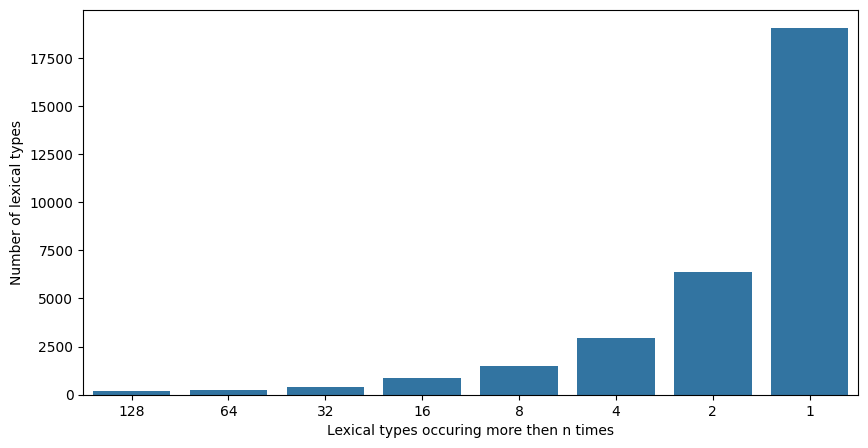

In [105]:
counts = Counter(data)
freq_t = [128, 64, 32, 16, 8, 4, 2]
frequencies = [0] * 8

for word in counts:
    count = counts[word]
    placed = False
    for idx, freq in enumerate(freq_t):
        if count >= freq:
            frequencies[idx] += 1
            placed = True
            break
    if not placed:
        frequencies[7] += 1


# 2. Plot distributions
plt.figure(figsize=(10,5))
plt.xlabel('Lexical types occuring more then n times')
plt.ylabel('Number of lexical types')

labels = [128, 64, 32, 16, 8, 4, 2, 1]
sns.barplot(x=labels, y=frequencies, order=labels)
plt.show()

In [106]:
# STEP 1.5

from textwrap import wrap
rare = [w for w in counts if counts[w] == 1]
for line in wrap("   ".join(["{:15s}".format(w) for w in rare[:100]]), width=70):
  print(line)

akavhiringwa      neCyclone         pekudzidzira      vangafire
kuvarapa          Tsvangiridzo      vanobatsirwa      wevarwere
vatataura         Molline           kutoenda          vangafe
Fiona             zvokuita          kwekutakura       anorapwa
Kasanze           vatotakura        azorapwa          VaKasanze
ibooke            nezvekupinzwa     akaburitswa       ekuvadzinga
kugura            muchato           eCopa             kanova
ichisimudza       achiendesa        weArgentina       Sergio
Romero            kuEast            Rutherford        Jersy
zvinotamba        muCopa            mumapenalty       TyC
yekuArgentina     Amira             uuyu              nemapfumvamwe
haan              weCopa            kwapinda          rechina
vachidzoserwa     kuchingorapwa     vachinyanya       semadzimai
pakuzvara         nasekuru          kuzvimba          Mabande
wemadhokotera     rakawanda         rechipatara       rinorapa
Outpatients       rakavharwa        chakapiwa         Nar

In [107]:

le=LabelEncoder()
def collate_NER(train, t_labels, test, tt_labels):
    raw_text = train + test
    vocabulary = set(raw_text)
    word_to_num = {}
    num_to_word = {}
    label_to_string = {}
    string_to_label = {}

    for num, word in enumerate(vocabulary):
      word_to_num[word] = num
      num_to_word[num] = word

    all_labels = set(t_labels + tt_labels)
    for cluster, label in enumerate(all_labels):
      label_to_string[label] = cluster
      string_to_label[cluster] = label

    train_num = [word_to_num[entry] for entry in train]
    t_labels_num = [label_to_string[tag] for tag in t_labels]
    test_num = [word_to_num[t_entry] for t_entry in test]
    tt_labels_num = [label_to_string[t_tag] for t_tag in tt_labels]


    return train_num, t_labels_num, test_num, tt_labels_num, word_to_num, num_to_word, label_to_string, string_to_label

In [108]:
train_num, t_labels_num, test_num, tt_labels_num, word_to_num, num_to_word, label_to_string, string_to_label = collate_NER(df_1[0].tolist(),df_1[1].tolist(),df_3[0].tolist(),df_3[1].tolist())

train = torch.LongTensor(train_num)  # Convert training data
t_labels = torch.LongTensor(t_labels_num)
valid = torch.LongTensor(test_num)  # Convert test data
v_labels = torch.LongTensor(tt_labels_num)

print(train)
print(valid)
print(t_labels)
print(v_labels)


tensor([ 3843,  6187,  7532,  ..., 24124, 15809,  5393])
tensor([24741, 25423,  4762,  ...,  9883,  7693, 26607])
tensor([5, 5, 5,  ..., 7, 5, 5])
tensor([5, 5, 2,  ..., 5, 5, 5])


#Inertia

Definition: Inertia measures the sum of squared distances between each data point and the centroid of the cluster to which it belongs. Lower inertia indicates tighter and more cohesive clusters.
Role in K-means: Inertia helps evaluate the quality of clustering by quantifying how well the clusters represent the data points.


#Elbow Method

Purpose: The Elbow Method identifies the optimal number of clusters by plotting inertia against the number of clusters (k). The "elbow point" marks the best trade-off between reducing inertia and increasing the number of clusters.
Key Insight: Adding more clusters always reduces inertia, but after a certain point, the improvement diminishes. The "elbow" is where inertia reduction slows significantly


/tmp/ipython-input-3703663044.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data, device='cuda')


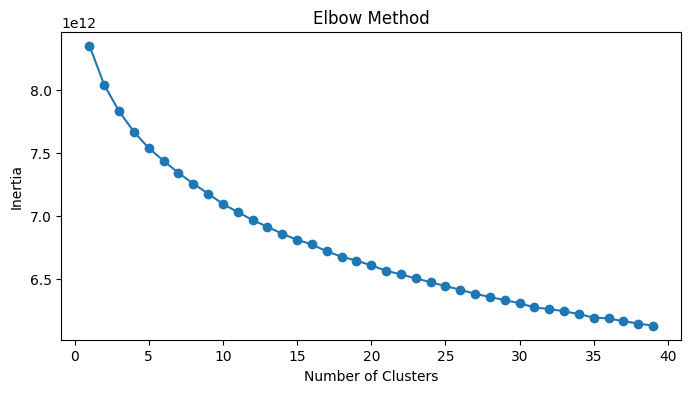

In [109]:

# STEP 2.2

# Parameters
batch_size = 20
seq_len = 35

# Tell Torch to use a GPU for computation
#Had to use the CPU for this verison
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
# Setting the random seed decreases variability
# Remove next three lines if running on your laptop
torch.cuda.manual_seed(random.randint(1, 10000))
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# citation: https://github.com/pytorch/examples/tree/master/word_language_model
def batchify(data, bsz):
    # Work out how cleanly we can divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    data = data[:nbatch * bsz]
    data = data.view(bsz, -1).t().contiguous()  # (seq_len, batch)
    return torch.tensor(data, device='cuda')

train = batchify(train, batch_size)
inertia = []
K = range(1, 40)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(train.cpu())
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


#Dendrogram

Definition: A dendrogram is a tree-like diagram used in hierarchical clustering to visualize the process of merging data points into clusters based on their similarity.
Use in K-means: While not directly used in K-means, dendrograms can help determine the number of clusters by analyzing the largest vertical distance (linkage) between two horizontal lines before merging clusters.



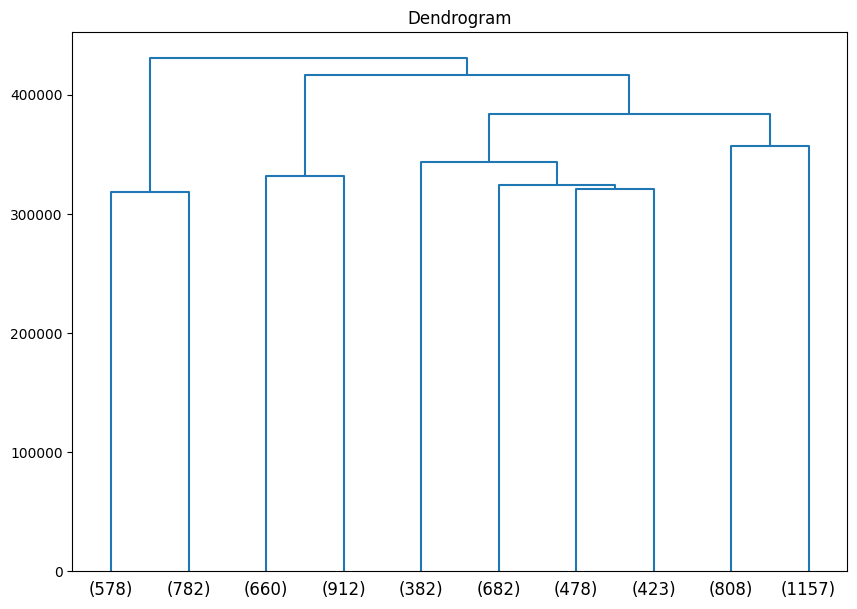

In [110]:
from scipy.cluster.hierarchy import dendrogram, linkage
# Hierarchical Clustering Dendrogram
linked = linkage(train.cpu(), 'ward')
plt.figure(figsize=(10, 7))
dendrogram(linked, truncate_mode='lastp', p=10)
plt.title('Dendrogram')
plt.show()


K-Means Clustering

Definition: K-Means is an unsupervised machine learning algorithm that partitions data into k clusters, where each data point belongs to the cluster with the nearest centroid, minimizing intra-cluster variance.
Process: The algorithm iteratively:




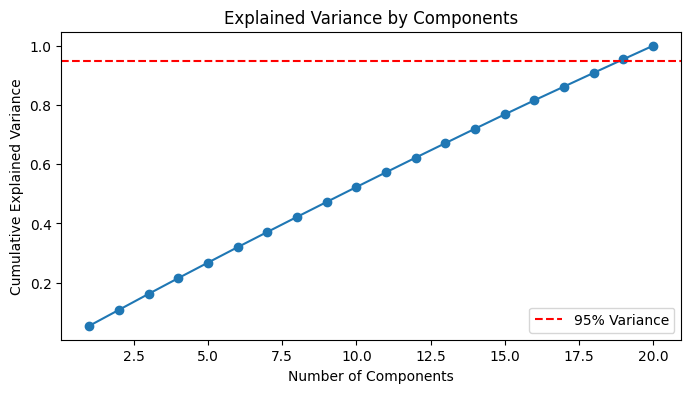

In [111]:
# PCA for Dimensionality Reduction
from sklearn.decomposition import PCA
pca = PCA()
pca_features = pca.fit_transform(train.cpu())
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.show()

In [112]:
# Run K-means
optimal_clusters = 9  # Based on elbow/dendrogram
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(train.cpu())
train_clustered = torch.cat([torch.tensor(train, device='cuda'), torch.tensor(clusters, dtype=torch.long, device='cuda').view(-1, 1)], dim=1)

display(train_clustered)

/tmp/ipython-input-1824982136.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_clustered = torch.cat([torch.tensor(train, device='cuda'), torch.tensor(clusters, dtype=torch.long, device='cuda').view(-1, 1)], dim=1)


tensor([[ 3843, 18564,  7039,  ...,  4128, 11981,     7],
        [ 6187, 18667, 26607,  ...,  2757,  7489,     1],
        [ 7532, 20249,  1989,  ..., 22981, 26607,     2],
        ...,
        [ 3931,   815, 14532,  ..., 18147, 24124,     3],
        [ 4858, 18205, 10368,  ...,  9378, 15809,     8],
        [17276, 25728, 22671,  ..., 12295,  5393,     5]], device='cuda:0')

Principal Component Analysis
PCA in K-Means

Purpose: Principal Component Analysis (PCA) reduces the dimensionality of the dataset while preserving as much variance as possible. In K-Means, PCA helps visualize clusters in 2D or 3D space and improves performance by removing noise and redundant features.
How It Helps: PCA transforms data into a set of principal components, which are linear combinations of the original features. This aids K-Means by simplifying complex datasets and making clusters more distinct in reduced dimensions.



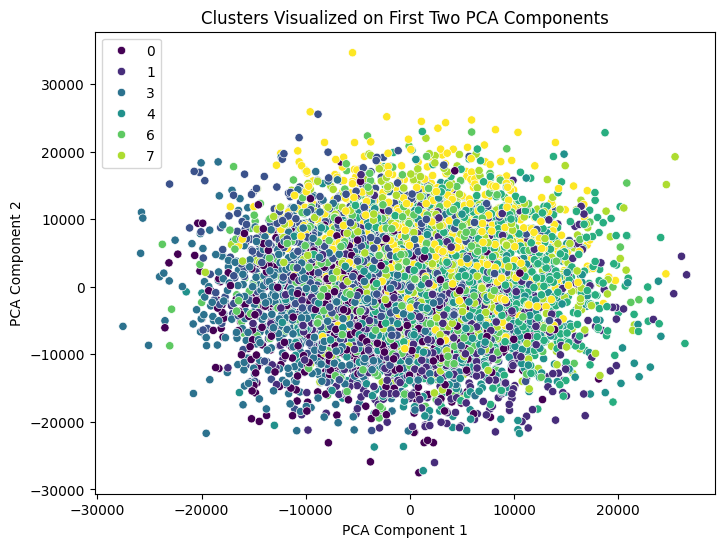

In [113]:
# Visualize Clusters
pca_2d = pca_features[:, :2]
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_2d[:, 0], y=pca_2d[:, 1], hue=clusters, palette='viridis')
plt.title('Clusters Visualized on First Two PCA Components')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

In [114]:
print(f"Shape of train tensor before batchify: {train.shape}")
print(f"Data type of train tensor before batchify: {train.dtype}")
print(f"Shape of valid tensor before batchify: {valid.shape}")
print(f"Data type of valid tensor before batchify: {valid.dtype}")

# The batchify function reshapes the data into (sequence_length, batch_size)
# KMeans expects (n_samples, n_features). We need to flatten the batched data.

train_reshaped = train.view(-1, 1)
valid_reshaped = valid.view(-1, 1)

print(f"Shape of train tensor after reshaping: {train_reshaped.shape}")
print(f"Data type of train tensor after reshaping: {train_reshaped.dtype}")
print(f"Shape of valid tensor after reshaping: {valid_reshaped.shape}")
print(f"Data type of valid tensor after reshaping: {valid_reshaped.dtype}")

# KMeans requires numpy arrays, so convert the tensors
train_np = train_reshaped.cpu().numpy()
valid_np = valid_reshaped.cpu().numpy()

print(f"Shape of train numpy array: {train_np.shape}")
print(f"Data type of train numpy array: {train_np.dtype}")
print(f"Shape of valid numpy array: {valid_np.shape}")
print(f"Data type of valid numpy array: {valid_np.dtype}")

# Update the train variable to the reshaped numpy array for subsequent steps
train = train_np
valid = valid_np

Shape of train tensor before batchify: torch.Size([6862, 20])
Data type of train tensor before batchify: torch.int64
Shape of valid tensor before batchify: torch.Size([20080])
Data type of valid tensor before batchify: torch.int64
Shape of train tensor after reshaping: torch.Size([137240, 1])
Data type of train tensor after reshaping: torch.int64
Shape of valid tensor after reshaping: torch.Size([20080, 1])
Data type of valid tensor after reshaping: torch.int64
Shape of train numpy array: (137240, 1)
Data type of train numpy array: int64
Shape of valid numpy array: (20080, 1)
Data type of valid numpy array: int64


## Apply k-means clustering
Perform K-means clustering on the prepared data to get cluster assignments on the prepared training and validation data.


In [115]:
# Determine the optimal number of clusters (k) based on the previously generated Elbow Method plot and Dendrogram.
# The elbow method plot shows a gradual decrease in inertia with increasing clusters.
# The dendrogram suggests a possible number of clusters around 9 or 10.
# Let's choose 9 as the optimal number of clusters, which corresponds to the number of unique NER labels.
optimal_clusters = 9
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
train_clusters = kmeans.fit_predict(train)
valid_clusters = kmeans.predict(valid)

print("Train clusters shape:", train_clusters.shape)
print("Valid clusters shape:", valid_clusters.shape)

Train clusters shape: (137240,)
Valid clusters shape: (20080,)


In [116]:
class EnsembleLSTM(nn.Module):
    """
    LSTM that receives [B, K, T, E] and returns [B, T, H]
    by concatenating outputs along the hidden dim and then
    projecting back to hidden_dim.
    Modified to handle [B, T, E] input when K=1.
    """
    def __init__(self, embed_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(embed_dim * 2, hidden_dim, batch_first=True) # Input size is word + cluster embedding

    def forward(self, x_emb):
        # x_emb : [B, K, T, E] or [B, T, E]
        if x_emb.dim() == 4:
            B, K, T, E = x_emb.shape
            x_emb = x_emb.view(B * K, T, E)  # treat as larger batch
            out, _ = self.lstm(x_emb)  # [B*K, T, H]
            out = out.view(B, K, T, -1)  # [B, K, T, H]
            out = out.permute(0, 2, 1, 3).contiguous()  # [B, T, K, H]
            out = out.view(B, T, -1)  # [B, T, K*H]
            return out
        elif x_emb.dim() == 3:
            # Assume x_emb is [B, T, E] when K=1
            out, _ = self.lstm(x_emb) # [B, T, H]
            return out
        else:
            raise ValueError(f"Unexpected input shape: {x_emb.shape}")

In [117]:
class BayesianLinear(nn.Module):
    """
    Variational layer as in Blundell et al. (2015) – Bayes by Backprop.
    """
    def __init__(self, in_f, out_f, prior_sigma=1.0):
        super().__init__()
        self.in_f, self.out_f, self.prior_sigma = in_f, out_f, prior_sigma
        # ρ = log(1+exp(σ)) trick
        self.w_mu  = nn.Parameter(torch.zeros(out_f, in_f))
        self.w_rho = nn.Parameter(torch.ones(out_f, in_f)*-3)
        self.b_mu  = nn.Parameter(torch.zeros(out_f))
        self.b_rho = nn.Parameter(torch.ones(out_f)*-3)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1/math.sqrt(self.in_f)
        nn.init.uniform_(self.w_mu, -std, std)
        nn.init.uniform_(self.b_mu, -std, std)

    def forward(self, x):
        w_sigma = F.softplus(self.w_rho)
        b_sigma = F.softplus(self.b_rho)
        eps_w = torch.randn_like(self.w_mu)
        eps_b = torch.randn_like(self.b_mu)
        w = self.w_mu + w_sigma * eps_w
        b = self.b_mu + b_sigma * eps_b
        return F.linear(x, w, b)

    def kl_loss(self):
        prior = Normal(0, self.prior_sigma)
        w_post = Normal(self.w_mu, F.softplus(self.w_rho))
        b_post = Normal(self.b_mu, F.softplus(self.b_rho))
        return kl_divergence(w_post, prior).sum() + kl_divergence(b_post, prior).sum()


In [118]:
class NERModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_clusters):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embedding_dim)
        self.cluster_embedding = nn.Embedding(num_clusters, embedding_dim) # Embedding for clusters
        self.lstm =  EnsembleLSTM(embedding_dim, hidden_dim) # Use the modified EnsembleLSTM
        self.fc = BayesianLinear(hidden_dim, output_dim) # Changed output of fc to output_dim

    def forward(self, text, clusters):   #x : [B, T] for text, [B, T] for clusters
        emb = self.embed(text) # [B, T, E]
        cluster_embedded = self.cluster_embedding(clusters) # [B, T, E]
        combined_embedded = torch.cat((emb, cluster_embedded), dim=2) #  [B, T, E*2]
        lstm_out = self.lstm(combined_embedded)  # [B, T, H]
        return self.fc(lstm_out)      # [B, T, output_dim]

    def kl_loss(self):
        return self.fc.kl_loss()

    def predict(self, text, clusters):
        """Prediction method for NER"""
        with torch.no_grad():
            logits = self.forward(text, clusters)
            predictions = torch.argmax(logits, dim=-1)
        return predictions



# Parameters
vocab_size = len(word_to_num)
embedding_dim = 100
hidden_dim = 256
output_dim = len(label_to_string)
num_clusters = optimal_clusters # Use the optimal number of clusters found earlier

# Instantiate the model
model = NERModel(vocab_size, embedding_dim, hidden_dim, output_dim, num_clusters).to(device)

print(model)

NERModel(
  (embed): Embedding(27307, 100)
  (cluster_embedding): Embedding(9, 100)
  (lstm): EnsembleLSTM(
    (lstm): LSTM(200, 256, batch_first=True)
  )
  (fc): BayesianLinear()
)


In [121]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

def batchify_data_and_clusters(data, clusters, labels, bsz, seq_len):
    num_elements = data.size(0)
    elements_per_batch_seq = bsz * seq_len
    num_batches = num_elements // elements_per_batch_seq

    data_batched = data[:num_batches * elements_per_batch_seq].view(num_batches, bsz, seq_len).to(device)
    clusters_batched = clusters[:num_batches * elements_per_batch_seq].view(num_batches, bsz, seq_len).to(device)
    labels_batched = labels[:num_batches * elements_per_batch_seq].view(num_batches, bsz, seq_len).to(device)

    return data_batched, clusters_batched, labels_batched

def popu(list_q):
    data =[]
    code = []
    for aline in list_q:
        if aline.strip():
            token, label = aline.split()
            data.append(str(token))
            code.append(label)
    return data, code


train_num_original = [word_to_num[entry] for entry in df_1[0].tolist()]
test_num_original = [word_to_num[t_entry] for t_entry in df_3[0].tolist()]
t_labels_num_original = [label_to_string[tag] for tag in df_1[1].tolist()]
v_labels_num_original = [label_to_string[t_tag] for t_tag in df_3[1].tolist()]

train_original_tensor = torch.LongTensor(train_num_original)
valid_original_tensor = torch.LongTensor(test_num_original)
t_labels_original_tensor = torch.LongTensor(t_labels_num_original)
v_labels_original_tensor = torch.LongTensor(v_labels_num_original)

# Apply KMeans to the flattened data
train_flat_np = train_original_tensor.view(-1, 1).cpu().numpy()
valid_flat_np = valid_original_tensor.view(-1, 1).cpu().numpy()

optimal_clusters = 9
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
train_clusters_flat = kmeans.fit_predict(train_flat_np)
valid_clusters_flat = kmeans.predict(valid_flat_np)

train_clusters_original_shape = torch.tensor(train_clusters_flat, dtype=torch.long).to(device)
valid_clusters_original_shape = torch.tensor(valid_clusters_flat, dtype=torch.long).to(device)

# Apply the batching
train_data_batched, train_clusters_batched, train_labels_batched = batchify_data_and_clusters(
    train_original_tensor.to(device), train_clusters_original_shape, t_labels_original_tensor.to(device), batch_size, seq_len
)
valid_data_batched, valid_clusters_batched, valid_labels_batched = batchify_data_and_clusters(
    valid_original_tensor.to(device), valid_clusters_original_shape, v_labels_original_tensor.to(device), batch_size, seq_len
)


def train(model, train_data, train_clusters, train_labels, valid_data, valid_clusters, valid_labels, criterion, optimizer, epochs=100):
    model.train()
    for epoch in range(epochs):
        start_time = time.time()
        total_loss = 0

        kl_loss_total = 0 # Add variable for KL loss
        # Iterate through batches
        for i in range(len(train_data)):
            inputs = train_data[i].to(device)
            clusters = train_clusters[i].to(device)
            labels = train_labels[i].to(device)

            optimizer.zero_grad()
            outputs = model(inputs, clusters)

            # Reshape outputs and labels for CrossEntropyLoss
            outputs = outputs.view(-1, outputs.shape[-1])
            labels = labels.view(-1)

            # Calculate CrossEntropyLoss
            cross_entropy_loss = criterion(outputs, labels)

            # Calculate KL Divergence Loss
            kl_loss = model.kl_loss()

            # Combine losses
            loss = cross_entropy_loss + kl_loss

            loss = cross_entropy_loss + kl_weight * kl_loss

            loss.backward()
            optimizer.step()

            total_loss += cross_entropy_loss.item() # Log cross entropy loss
            kl_loss_total += kl_loss.item() # Log KL loss

        avg_train_loss = total_loss / len(train_data)
        avg_train_kl_loss = kl_loss_total / len(train_data) # Calculate average KL loss

         # Validation
        model.eval()
        valid_loss = 0
        valid_kl_loss = 0
        with torch.no_grad():
            for i in range(len(valid_data)):
                inputs = valid_data[i].to(device)
                clusters = valid_clusters[i].to(device)
                labels = valid_labels[i].to(device)

                outputs = model(inputs, clusters)
                outputs = outputs.view(-1, outputs.shape[-1])
                labels = labels.view(-1)

                # Calculate CrossEntropyLoss
                cross_entropy_loss = criterion(outputs, labels)

                # Calculate KL Divergence Loss
                kl_loss = model.kl_loss()

                valid_loss += cross_entropy_loss.item() # Log cross entropy loss
                valid_kl_loss += kl_loss.item() # Log KL loss
                # if valid_loss < best_val:
                #   best_val = valid_loss
                #   torch.save(model.state_dict(), Path(cfg["checkpoint_dir"])/"/unbootstrapped/best.pt")


        avg_valid_loss = valid_loss / len(valid_data)
        avg_valid_kl_loss = valid_kl_loss / len(valid_data) # Calculate average KL loss


        end_time = time.time()
        epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

        print(f'Fine-tuning Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs:.2f}s')
        print(f'\tTrain Loss (CE): {avg_train_loss:.3f} | Train Loss (KL): {avg_train_kl_loss:.6f}')
        print(f'\tValidation Loss (CE): {avg_valid_loss:.3f} | Validation Loss (KL): {avg_valid_kl_loss:.6f}')
        model.train()

#Start training
train(
    model, train_data_batched, train_clusters_batched, train_labels_batched,
    valid_data_batched, valid_clusters_batched, valid_labels_batched,
    criterion, optimizer, epochs=100
)

Fine-tuning Epoch: 01 | Time: 0.0m 2.18s
	Train Loss (CE): 0.003 | Train Loss (KL): 5841.166155
	Validation Loss (CE): 0.457 | Validation Loss (KL): 5613.048828
Fine-tuning Epoch: 02 | Time: 0.0m 2.10s
	Train Loss (CE): 0.003 | Train Loss (KL): 5392.008645
	Validation Loss (CE): 0.436 | Validation Loss (KL): 5170.149902
Fine-tuning Epoch: 03 | Time: 0.0m 2.50s
	Train Loss (CE): 0.003 | Train Loss (KL): 4953.160929
	Validation Loss (CE): 0.437 | Validation Loss (KL): 4735.688477
Fine-tuning Epoch: 04 | Time: 0.0m 2.11s
	Train Loss (CE): 0.002 | Train Loss (KL): 4522.768438
	Validation Loss (CE): 0.422 | Validation Loss (KL): 4309.175293
Fine-tuning Epoch: 05 | Time: 0.0m 2.11s
	Train Loss (CE): 0.002 | Train Loss (KL): 4101.601054
	Validation Loss (CE): 0.428 | Validation Loss (KL): 3893.871582
Fine-tuning Epoch: 06 | Time: 0.0m 2.07s
	Train Loss (CE): 0.002 | Train Loss (KL): 3692.157827
	Validation Loss (CE): 0.437 | Validation Loss (KL): 3491.592773
Fine-tuning Epoch: 07 | Time: 0.0m

In [122]:
# Evaluate the ner model
model.eval()
true_labels = []
predicted_labels = []

# Iterate through the validation data batches
with torch.no_grad():
    for i in range(valid_data_batched.size(0)):
        inputs = valid_data_batched[i]  # [bsz, seq_len]
        clusters = valid_clusters_batched[i]  # [bsz, seq_len]
        labels = valid_labels_batched[i]  #  [bsz, seq_len]

        # Get model predictions
        outputs = model(inputs, clusters)

        # Get predicted cluster labels
        _, predicted = torch.max(outputs.data, dim=-1)
        true_labels.extend(labels.view(-1).cpu().numpy())
        predicted_labels.extend(predicted.view(-1).cpu().numpy())

true_labels_np = np.array(true_labels)
predicted_labels_np = np.array(predicted_labels)

# Convert target names to strings
target_names = [str(name) for name in string_to_label.keys()]
print(classification_report(true_labels_np, predicted_labels_np, target_names=target_names))

              precision    recall  f1-score   support

           0       0.69      0.73      0.71       716
           1       0.83      0.74      0.78       431
           2       0.59      0.69      0.64       404
           3       0.66      0.56      0.61       149
           4       0.72      0.81      0.76       251
           5       0.97      0.96      0.97     16196
           6       0.73      0.75      0.74       128
           7       0.82      0.80      0.81       697
           8       0.65      0.69      0.67       628

    accuracy                           0.92     19600
   macro avg       0.74      0.75      0.74     19600
weighted avg       0.93      0.92      0.92     19600



In [123]:
def batchify_boot(data, bsz, seq_len):
    if not isinstance(data, torch.Tensor):
        data = torch.tensor(data, dtype=torch.long)
    data = data.to(device)

    # Ensure data is 1D for text data, 1D for cluster labels
    if data.dim() > 1:
        data = data.squeeze()  # Remove extra dimensions

    num_elements = data.size(0)
    elements_per_batch_seq = bsz * seq_len
    num_batches = num_elements // elements_per_batch_seq

    if num_batches == 0:
        if num_elements > 0:
            # Pad for small batch
            padded = torch.zeros(elements_per_batch_seq, dtype=data.dtype, device=device)
            padded[:num_elements] = data
            return padded.view(bsz, seq_len).unsqueeze(0)  # [1, bsz, seq_len]
        else:
            return torch.empty(0, bsz, seq_len, device=device)

    data = data[:num_batches * elements_per_batch_seq]
    # Reshape to [num_batches, bsz, seq_len]
    data = data.view(num_batches, bsz, seq_len)
    return data

In [124]:
#Evaluate on the novel test data
vocabulary = set(df_2[0])
for num, word in enumerate(vocabulary):
      word_to_num[word] = num
      num_to_word[num] = word

all_labels = set(df_2[1])
for cluster, label in enumerate(all_labels):
      label_to_string[label] = cluster
      string_to_label[cluster] = label
test_n = [word_to_num[entry]for entry in df_2[0].tolist()]
test_n_labels = [label_to_string[tag_d] for tag_d in df_2[1].tolist()]
test_n=torch.LongTensor(test_n)
test_n_labels = torch.LongTensor(test_n_labels)
test_n = test_n.view(-1,1).cpu().numpy()
test_n_labels = test_n_labels.view(-1,1).cpu().numpy()
test_n_batched=batchify_boot(test_n, batch_size, seq_len)
kmeans_test = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
test_clusters_flat = kmeans.fit_predict(test_n)
test_n_labels_batched = batchify_boot(test_n_labels, batch_size, seq_len)
test_clusters_batched = batchify_boot(test_clusters_flat, batch_size, seq_len)

with torch.no_grad():
    for i in range(test_n_batched.size(0)):
        inputs = test_n_batched[i].to(device)  # [bsz, seq_len]
        clusters = test_clusters_batched[i].to(device)  # [bsz, seq_len]
        labels = test_n_labels_batched[i].to(device)  #  [bsz, seq_len]

        # Get model predictions
        outputs = model(inputs, clusters)

        # Get predicted cluster labels
        _, predicted = torch.max(outputs.data, dim=-1)
        true_labels.extend(labels.view(-1).cpu().numpy())
        predicted_labels.extend(predicted.view(-1).cpu().numpy())

true_labels_np = np.array(true_labels)
predicted_labels_np = np.array(predicted_labels)

target_names = [str(name) for name in string_to_label.keys()]
print(classification_report(true_labels_np, predicted_labels_np, target_names=target_names))

              precision    recall  f1-score   support

           0       0.23      0.28      0.25      2105
           1       0.26      0.27      0.26      1290
           2       0.14      0.26      0.19      1226
           3       0.22      0.19      0.20       449
           4       0.25      0.30      0.27       708
           5       0.88      0.85      0.87     47709
           6       0.42      0.26      0.32       371
           7       0.43      0.33      0.37      1803
           8       0.20      0.28      0.23      1739

    accuracy                           0.75     57400
   macro avg       0.34      0.34      0.33     57400
weighted avg       0.78      0.75      0.77     57400



In [125]:
from pathlib import Path
kl_weight = 0.0001
SEED = 42
cfg = {
    "data_root": "/content/content/",
    "vocab_min_freq": 0,
    "max_len": 64,
    "batch_size": 32,
    "embed_dim": 128,
    "hidden_dim": 256,
    "lr": 1e-3,
    "mlm_prob": 0.15,
    "epochs": 100,
    "ensemble_masks": 5,
    "patience": 5,
    "checkpoint_dir": "/content/content/checkpoint",
    "seed": SEED,
}
def fine_tune(checkpoint_dir, model, train_data, train_clusters, train_labels,
              valid_data, valid_clusters, valid_labels, criterion, optimizer,
              current_itos, num_ner_labels,
              epochs=100, device='cuda'):

    try:
        checkpoint_path = Path(checkpoint_dir) / "best.pt"
        meta_path = Path(checkpoint_dir) / "meta.json"

        if not checkpoint_path.exists() or not meta_path.exists():
            print("Checkpoint files not found, training from scratch")
            # Train from scratch if checkpoint is not found
            train(
                model, train_data, train_clusters, train_labels,
                valid_data, valid_clusters, valid_labels,
                criterion, optimizer, epochs=epochs
            )
            return

        # Load checkpoint and metadata
        checkpoint = torch.load(checkpoint_path, map_location=device)
        with open(meta_path, "r") as f:
            meta = json.load(f)

        # Load vocabularies
        checkpoint_itos = meta.get("itos", []) # Use get with default empty list
        checkpoint_stoi = {tok: idx for idx, tok in enumerate(checkpoint_itos)}
        current_stoi = {tok: idx for idx, tok in enumerate(current_itos)}

        # Identify common tokens and novel words
        embedding_dim = model.embed.embedding_dim
        old_vocab_size = len(checkpoint_itos)
        new_vocab_size = len(current_itos)

        print(f"Checkpoint vocabulary size: {old_vocab_size}")
        print(f"Current vocabulary size: {new_vocab_size}")

        # Build new embedding layer
        new_embedding = nn.Embedding(new_vocab_size, embedding_dim).to(device) # Create on device

        # Copy embeddings from checkpoint for tokens that exist in both vocabs
        # Ensure checkpoint_state_dict key exists
        if 'model_state_dict' in checkpoint and 'embed.weight' in checkpoint['model_state_dict']:
            pretrained_embeddings = checkpoint['model_state_dict']['embed.weight'].to(device) # Move to device
            print("Loading embeddings for common vocabulary...")
            for tok, new_idx in current_stoi.items():
                if tok in checkpoint_stoi:
                    old_idx = checkpoint_stoi[tok]
                    new_embedding.weight.data[new_idx].copy_(pretrained_embeddings[old_idx])
                else:
                    # Initialize token randomly on device
                    new_embedding.weight.data[new_idx].normal_(mean=0, std=0.02)
            # Replace model's embedding layer
            model.embed = new_embedding
            print("Embedding layer adapted.")
        else:
             print("Embedding weights not found in checkpoint. Initializing embedding layer from scratch.")
        # This handles size mismatches by only loading layers with matching shapes
        checkpoint_state_dict = checkpoint.get('model_state_dict', checkpoint) # Try 'model_state_dict' key first
        model_state_dict = model.state_dict()
        print("Loading other layers with matching shapes...")
        for name, param in checkpoint_state_dict.items():
            # Check if layer name exists in current model and shapes match
            if name in model_state_dict and model_state_dict[name].shape == param.shape:
                print(f"Loading weights for layer: {name}")
                model_state_dict[name].copy_(param.to(device)) # Ensure param is on the correct device
            elif name == 'embed.weight':
                # Skip embed.weight as it's handled separately
                continue
            else:
                print(f'Skipping layer {name} due to size mismatch or not found.')

        # Load the updated state dict into the model
        # strict=False to allow for layers that were skipped
        model.load_state_dict(model_state_dict, strict=False)
        print("Model state dictionary loaded (ignoring size mismatches).")


        print(f"Fine-tuning started with adapted model.")

    except Exception as e:
        print(f"Could not load checkpoint for fine-tuning: {e}\nTraining from scratch")
        # Train from scratch if loading fails
        train(
            model, train_data, train_clusters, train_labels,
            valid_data, valid_clusters, valid_labels,
            criterion, optimizer, epochs=epochs
        )
        return

    # Task Adaptive Training Loop
    for epoch in range(epochs):
        start_time = time.time()
        total_loss = 0
        kl_loss_total = 0
        model.train()
        best_val, patience_left = 1e9, cfg["patience"]
        for i in range(len(train_data)):
            inputs = train_data[i].to(device)
            clusters = train_clusters[i].to(device)
            labels = train_labels[i].to(device)

            optimizer.zero_grad()
            outputs = model(inputs, clusters)

            # Reshape outputs and labels for CrossEntropyLoss
            outputs = outputs.view(-1, outputs.shape[-1])
            labels = labels.view(-1)

            # Calculate CrossEntropyLoss
            cross_entropy_loss = criterion(outputs, labels)

            # Calculate KL Divergence Loss
            kl_loss = model.kl_loss()

            # Combine losses
            loss = cross_entropy_loss + kl_loss

            loss = cross_entropy_loss + kl_weight * kl_loss

            loss.backward()
            optimizer.step()

            total_loss += cross_entropy_loss.item() # Log cross entropy loss
            kl_loss_total += kl_loss.item() # Log KL loss

        avg_train_loss = total_loss / len(train_data)
        avg_train_kl_loss = kl_loss_total / len(train_data) # Calculate average KL loss

        # Validation
        model.eval()
        valid_loss = 0
        valid_kl_loss = 0
        with torch.no_grad():
            for i in range(len(valid_data)):
                inputs = valid_data[i].to(device)
                clusters = valid_clusters[i].to(device)
                labels = valid_labels[i].to(device)

                outputs = model(inputs, clusters)
                outputs = outputs.view(-1, outputs.shape[-1])
                labels = labels.view(-1)

                # Calculate CrossEntropyLoss
                cross_entropy_loss = criterion(outputs, labels)

                # Calculate KL Divergence Loss
                kl_loss = model.kl_loss()

                valid_loss += cross_entropy_loss.item() # Log cross entropy loss
                valid_kl_loss += kl_loss.item() # Log KL loss
                # if valid_loss < best_val:
                #   best_val = valid_loss
                #   torch.save(model.state_dict(), Path(cfg["checkpoint_dir"])/"/bootstrapped/best.pt")


        avg_valid_loss = valid_loss / len(valid_data)
        avg_valid_kl_loss = valid_kl_loss / len(valid_data) # Calculate average KL loss


        end_time = time.time()
        epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

        print(f'Fine-tuning Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs:.2f}s')
        print(f'\tTrain Loss (CE): {avg_train_loss:.3f} | Train Loss (KL): {avg_train_kl_loss:.6f}')
        print(f'\tValidation Loss (CE): {avg_valid_loss:.3f} | Validation Loss (KL): {avg_valid_kl_loss:.6f}')


fine_tune(
    checkpoint_dir="/content/content/checkpoint/",
    model=model,
    train_data=train_data_batched,
    train_clusters=train_clusters_batched,
    train_labels=train_labels_batched,
    valid_data=valid_data_batched,
    valid_clusters=valid_clusters_batched,
    valid_labels=valid_labels_batched,
    criterion=criterion,
    optimizer=optimizer,
    current_itos=[w for i, w in enumerate(data)],           # current vocabulary list (index to string)
    num_ner_labels=len(string_to_label.keys()),       # number of NER classes
    epochs=100,
    device=device

)

# Evaluate the ner model
model.eval()
true_labels = []
predicted_labels = []

# Iterate through the validation data batches
with torch.no_grad():
    for i in range(valid_data_batched.size(0)):
        inputs = valid_data_batched[i]  # [bsz, seq_len]
        clusters = valid_clusters_batched[i]  # [bsz, seq_len]
        labels = valid_labels_batched[i]  #  [bsz, seq_len]

        # Get model predictions
        outputs = model(inputs, clusters)

        # Get predicted cluster labels
        _, predicted = torch.max(outputs.data, dim=-1)
        true_labels.extend(labels.view(-1).cpu().numpy())
        predicted_labels.extend(predicted.view(-1).cpu().numpy())

true_labels_np = np.array(true_labels)
predicted_labels_np = np.array(predicted_labels)

# Convert target names to strings
target_names = [str(name) for name in string_to_label.keys()]
print(classification_report(true_labels_np, predicted_labels_np, target_names=target_names))

Checkpoint vocabulary size: 27307
Current vocabulary size: 195780
Embedding weights not found in checkpoint. Initializing embedding layer from scratch.
Loading other layers with matching shapes...
Skipping layer lstm.lstm.weight_ih_l0 due to size mismatch or not found.
Loading weights for layer: lstm.lstm.weight_hh_l0
Loading weights for layer: lstm.lstm.bias_ih_l0
Loading weights for layer: lstm.lstm.bias_hh_l0
Skipping layer lstm.merge.weight due to size mismatch or not found.
Skipping layer lstm.merge.bias due to size mismatch or not found.
Skipping layer fc.w_mu due to size mismatch or not found.
Skipping layer fc.w_rho due to size mismatch or not found.
Skipping layer fc.b_mu due to size mismatch or not found.
Skipping layer fc.b_rho due to size mismatch or not found.
Model state dictionary loaded (ignoring size mismatches).
Fine-tuning started with adapted model.
Fine-tuning Epoch: 01 | Time: 0.0m 2.45s
	Train Loss (CE): 0.126 | Train Loss (KL): 147.367727
	Validation Loss (CE): 

In [126]:
with torch.no_grad():
    for i in range(test_n_batched.size(0)):
        inputs = test_n_batched[i].to(device)  # [bsz, seq_len]
        clusters = test_clusters_batched[i].to(device)  # [bsz, seq_len]
        labels = test_n_labels_batched[i].to(device)  #  [bsz, seq_len]

        # Get model predictions
        outputs = model(inputs, clusters)

        # Get predicted cluster labels
        _, predicted = torch.max(outputs.data, dim=-1)
        true_labels.extend(labels.view(-1).cpu().numpy())
        predicted_labels.extend(predicted.view(-1).cpu().numpy())

true_labels_np = np.array(true_labels)
predicted_labels_np = np.array(predicted_labels)

target_names = [str(name) for name in string_to_label.keys()]
print(classification_report(true_labels_np, predicted_labels_np, target_names=target_names))

              precision    recall  f1-score   support

           0       0.19      0.29      0.23      2105
           1       0.28      0.25      0.26      1290
           2       0.16      0.25      0.19      1226
           3       0.25      0.22      0.23       449
           4       0.39      0.31      0.34       708
           5       0.88      0.85      0.87     47709
           6       0.54      0.26      0.36       371
           7       0.54      0.31      0.40      1803
           8       0.19      0.30      0.23      1739

    accuracy                           0.76     57400
   macro avg       0.38      0.34      0.35     57400
weighted avg       0.78      0.76      0.77     57400



In [127]:
MORPHEMES =  {
    1: {"noun": "mu", "subject": "a", "adjective": "mu"},
    2: {"noun": "va", "subject": "va", "adjective": "va"},
    3: {"noun": "mu", "subject": "u", "adjective": "mu"},
    4: {"noun": "mi", "subject": "i", "adjective": "mi"},
    5: {"noun": "ri", "subject": "ri", "adjective": "ri"},
    6: {"noun": "ma", "subject": "a", "adjective": "ma"},
    7: {"noun": "chi", "subject": "chi", "adjective": "chi"},
    8: {"noun": "zvi", "subject": "zvi", "adjective": "zvi"},
    9: {"noun": "n", "subject": "dzi", "adjective": "dzi"},
    10: {"noun": "n", "subject": "dzi", "adjective": "dzi"},
    11: {"noun": "ru", "subject": "ru", "adjective": "ru"},
    12: {"noun": "ka", "subject": "ka", "adjective": "ka"},
    13: {"noun": "tu", "subject": "tu", "adjective": "tu"},
    14: {"noun": "u", "subject": "u", "adjective": "u"},
    15: {"noun": "ku", "subject": "ku", "adjective": "ku"},
    16: {"noun": "pa", "subject": "pa", "adjective": "pa"},
    17: {"noun": "ku", "subject": "ku", "adjective": "ku"},
    18: {"noun": "mu", "subject": "mu", "adjective": "mu"}
}


def edit_distance(a, b):
    la, lb = len(a), len(b)
    dp = [[i if j == 0 else j if i == 0 else 0 for j in range(lb + 1)] for i in range(la + 1)]

    for i in range(1, la + 1):
        for j in range(1, lb + 1):
            dp[i][j] = min(dp[i-1][j] + 1, dp[i][j-1] + 1, dp[i-1][j-1] + (a[i-1] != b[j-1]))

    return dp[la][lb]

def add_morphemes(text, prob=0.7):
    words = text.split()
    out = []
    sentences =[]
    s_p =""

    for w in words:
        if w in ".!?":
            sentences.append(s_p)
            s_p=""
        else:
            s_p=s_p+" "+w
    for sentence in sentences:
        words_s=sentence.strip().split()

    for w in words_s:
        has_morpheme = False
        class_num = None

        # Detect existing morphemes
        for cid, bundle in MORPHEMES.items():
            for morpheme in bundle.values():
                if w.lower().startswith(morpheme):
                    has_morpheme = True
                    class_num = cid
                    break

        if has_morpheme and random.random() < prob:
            # remove prefix (simulate simplifying)
            for morpheme in MORPHEMES[class_num].values():
                if w.lower().startswith(morpheme):
                    w = w[len(morpheme):]
                    break
            out.append(w)
        else:
            # add a random morpheme
            cid = random.choice(list(MORPHEMES.keys()))
            morph = random.choice(list(MORPHEMES[cid].values()))
            w = morph + w
            out.append(w)
    return " ".join(out)

def score(text, original, alpha=1.0, gamma=5.0):
    # Iterate through the values of the outer dictionary (the inner dictionaries)
    # and then iterate through the values of the inner dictionaries (the morphemes)
    morph_score = sum(text.count(morpheme) for bundle in MORPHEMES.values() for morpheme in bundle.values())

    if text.strip() == original.strip():
        penalty = gamma * 2
    elif abs(len(text) - len(original)) > len(original) // 10:
        penalty = 0
    elif edit_distance(text[:100], original[:100]) < 10:
        penalty = gamma
    else:
        penalty = 0

    return alpha * morph_score - penalty

def generate_paraphrases(model, text, n_passes=8, per_pass=4, top_k=5):
    for m in model.modules():
        if isinstance(m, torch.nn.Dropout):
            m.train()

    candidates = [{"text": add_morphemes(text), "score": 0} for _ in range(n_passes * per_pass)]
    for c in candidates:
        c["score"] = score(c["text"], text)

    candidates.sort(key=lambda x: x["score"], reverse=True)

    unique = []
    seen = set()

    for c in candidates:
        if c["text"] in seen:
            continue

        too_close = any(edit_distance(c["text"][:100], u["text"][:100]) < 10 for u in unique)

        if not too_close:
            unique.append(c)
            seen.add(c["text"])

        if len(unique) >= top_k:
            break

    return unique

# Demo
print("\n=== Agglutinative Paraphrasing ===")
try:
    with open("/content/Generations.txt") as f:
        input_text = f.read()
    #To run the paraphrase experiments comment out the next 3 lines and replace with file path for Paraphrases_raw
    results = generate_paraphrases(model, input_text, n_passes=6, per_pass=3)
    for i, c in enumerate(results, 1):
        print(f"Candidate {i} (Score: {c['score']:.2f}): {c['text']}")
except FileNotFoundError:
    print("Error: Generations.txt not found")

# Save
os.makedirs(cfg["checkpoint_dir"], exist_ok=True)
# Create the directory for saving the bootstrapped model if it doesn't exist
bootstrapped_dir = Path(cfg["checkpoint_dir"]) / "bootstrap_reduced"
bootstrapped_dir.mkdir(parents=True, exist_ok=True)

with open(Path(cfg["checkpoint_dir"]) / "meta.json", "w") as f:
    json.dump({"cfg": cfg, "itos": num_to_word, "stoi": word_to_num}, f, indent=2)
    torch.save(model.state_dict(), bootstrapped_dir / "best.pt")
print(f"\nSaved to {cfg['checkpoint_dir']}")


=== Agglutinative Paraphrasing ===
Candidate 1 (Score: 143.00): Moyo noti nhurumende nofanira chikufara chikuti mumvura musika paMutumbi ruKariba ro muyeRufaro
Candidate 2 (Score: 136.00): muVaMoyo noti dzihurumende dziinofanira fara mikuti chimvura musika tumbi riba kuiro muyeRufaro
Candidate 3 (Score: 136.00): Moyo noti nhurumende dziinofanira dzikufara ti dzimvura rupamusika tumbi muKariba uiro vayeRufaro
Candidate 4 (Score: 130.00): chiVaMoyo noti pahurumende nofanira vakufara ti mumvura musika kaMutumbi uKariba ro payeRufaro
Candidate 5 (Score: 129.00): Moyo noti pahurumende uinofanira fara mukuti tumvura musika tumbi miKariba kuiro ayeRufaro

Saved to /content/content/checkpoint


In [128]:
from sklearn.metrics import silhouette_score

# Evaluate clustering performance using the Silhouette Score
# The Silhouette Coefficient is calculated using the mean intra-cluster distance (a)
# and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient
# for a sample is (b - a) / max(a, b). The score is the mean Silhouette Coefficient
# over all samples. Scores range from -1 to +1. A high value indicates that the
# object is well matched to its own cluster and poorly matched to neighboring clusters.
# Source: scikit-learn documentation (https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient)
# train_np is the numpy array of the flattened training data used for KMeans fitting
# train_clusters is the array of cluster labels for the training data

try:
    # Silhouette Score
    # The silhouette score requires at least 2 clusters and the number of samples
    # must be greater than 1 for each cluster.
    if optimal_clusters > 1 and len(set(train_clusters)) > 1:
        silhouette_avg = silhouette_score(train_np, train_clusters)
        print(f"Silhouette Score: {silhouette_avg:.3f}")
    else:
        print("Cannot compute Silhouette Score: Requires at least 2 clusters and more than 1 sample per cluster.")

except Exception as e:
    print(f"An error occurred during clustering evaluation: {e}")
print(input_text)

Silhouette Score: 0.593

2.13E-52:  Vakuru . Asi mumwe mugari , Amai . . . . . . . . . . . . . . .
		. . . . . . . . . . . . . . . . . . . . . . . . . . . . .

2.18E-79:  Vakuru vanofunga kuti vanhu vazhinji zviri nevana vane dzimwe
		hama dzavo kana kuti mari . Munyori mukuru muMDC , VaObert Charamba ,
		vakaudza Studio 7 kuti kushaikwa Arabia mare , avo matatu kusvika pari
		zvino , uye masangano , vavo vakurudzira kuti tinzwe kuti pane mihoro
		nechirwere iri . Sangano rinomirira

1.16E-82:  Vakuru nemapurisa magwaro chete kuitira kuti makambani ipe
		mutungamiri wemapurisa , VaEmmerson Mnangagwa , avo vatungamiri mumwe
		chizvarwa ava , Amai Henry Mugabe , Highlanders nezvimwe mamwe
		Mashonaland na kupedza chikwata ichi . Asi chii mukuru yeZanu PF ,
		inotungamirwa Disease rezvekuburitswa kwemashoko , Doctor Monica
		Mutsvangwa , vanotiwo hurumende yavo

1.22E-87: Vakuru mashandiro chitsvambe , riri kutora mari yekunze kubva
		kuChegutu nezviuru mazana matatu . Munyori wesangano r

In [129]:
lines = df_1[0].tolist()
lines = " ".join(lines)
train_aug_tokens = (input_text+lines).split()
train_aug_tokens = [w  for w in train_aug_tokens if not(w==" ")]

# Rebuild word_to_num vocabulary to include words from augmented data
all_words_original = list(set(df_1[0].tolist() + df_2[0].tolist()))
all_words_augmented = list(set(train_aug_tokens))
all_words_combined = list(set(all_words_original + all_words_augmented))

word_to_num = {}
for i, word in enumerate(all_words_combined):
    word_to_num[word] = i

train_aug_original = [word_to_num[entry] for entry in train_aug_tokens]
train_aug_tensor = torch.LongTensor(train_aug_original)
# Apply batching to the augmented data
train_aug_batched_data = batchify_boot(train_aug_tensor, batch_size, seq_len)


print(f"Shape of augmented train batched data: {train_aug_batched_data.shape}")
train_np_aug = train_aug_batched_data.view(-1, 1).cpu().numpy()

print(f"Shape of augmented train numpy array for KMeans: {train_np_aug.shape}")
print(f"Data type of augmented train numpy array for KMeans: {train_np_aug.dtype}")


Shape of augmented train batched data: torch.Size([196, 20, 35])
Shape of augmented train numpy array for KMeans: (137200, 1)
Data type of augmented train numpy array for KMeans: int64


In [130]:
# ----------Simulate Low-Resource conditions by excluding the dev dataset from NER TAFT-----------------------------
kmeans_aug = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
train_aug_clusters_flat = kmeans_aug.fit_predict(train_np_aug)
# Convert to LongTensor for embedding lookup
train_aug_clusters_t = torch.LongTensor(train_aug_clusters_flat)

# Recreate augmented data batches using the potentially updated word_to_num
train_aug_original = [word_to_num[entry] for entry in train_aug_tokens if entry in word_to_num] # Ensure words exist in the updated vocabulary
train_aug_tensor = torch.LongTensor(train_aug_original)
train_aug_batched_data = batchify_boot(train_aug_tensor, batch_size, seq_len)

# Recreate augmented cluster batches
clusters_aug_batched_data = batchify_boot(train_aug_clusters_t, batch_size, seq_len)
embedding_dim = model.embed.embedding_dim
old_vocab_size = len(num_to_word)

new_vocab_size = len(all_words_combined)

print(f"Checkpoint vocabulary size: {old_vocab_size}")
print(f"Current vocabulary size: {new_vocab_size}")

new_embedding = nn.Embedding(new_vocab_size, embedding_dim).to(device)
model.embed = new_embedding
print("Embedding layer adapted.")
print("Embedding weights not found in checkpoint. Initializing embedding layer from scratch.")
model_state_dict = model.state_dict()
model.load_state_dict(model_state_dict, strict=False)
print("Model state dictionary loaded (ignoring size mismatches).")


fine_tune(
    "/content/content/checkpoint/",
    model=model,
    train_data=train_aug_batched_data.to(device),
    train_clusters=clusters_aug_batched_data.to(device),
    train_labels=clusters_aug_batched_data.to(device),
    valid_data=valid_data_batched,
    valid_clusters=valid_clusters_batched,
    valid_labels=valid_labels_batched,
    criterion=criterion,
    optimizer=optimizer,
    current_itos=[w for i, w in enumerate(data)],
    num_ner_labels=len(string_to_label.keys()),
    epochs=100,
    device=device

)

Checkpoint vocabulary size: 27307
Current vocabulary size: 29341
Embedding layer adapted.
Embedding weights not found in checkpoint. Initializing embedding layer from scratch.
Model state dictionary loaded (ignoring size mismatches).
Checkpoint vocabulary size: 27307
Current vocabulary size: 195780
Embedding weights not found in checkpoint. Initializing embedding layer from scratch.
Loading other layers with matching shapes...
Skipping layer lstm.lstm.weight_ih_l0 due to size mismatch or not found.
Loading weights for layer: lstm.lstm.weight_hh_l0
Loading weights for layer: lstm.lstm.bias_ih_l0
Loading weights for layer: lstm.lstm.bias_hh_l0
Skipping layer lstm.merge.weight due to size mismatch or not found.
Skipping layer lstm.merge.bias due to size mismatch or not found.
Skipping layer fc.w_mu due to size mismatch or not found.
Skipping layer fc.w_rho due to size mismatch or not found.
Skipping layer fc.b_mu due to size mismatch or not found.
Skipping layer fc.b_rho due to size misma

In [131]:
# Evaluate the ner model
model.eval()
true_labels = []
predicted_labels = []

# Iterate through the validation data batches
with torch.no_grad():
    for i in range(valid_data_batched.size(0)):
        inputs = valid_data_batched[i]  # [bsz, seq_len]
        clusters = valid_clusters_batched[i]  # [bsz, seq_len]
        labels = valid_labels_batched[i]  #  [bsz, seq_len]

        # Get model predictions
        outputs = model(inputs, clusters)

        # Get predicted cluster labels
        _, predicted = torch.max(outputs.data, dim=-1)
        true_labels.extend(labels.view(-1).cpu().numpy())
        predicted_labels.extend(predicted.view(-1).cpu().numpy())

true_labels_np = np.array(true_labels)
predicted_labels_np = np.array(predicted_labels)

# Convert target names to strings if they're integers
target_names = [str(name) for name in string_to_label.keys()]
print(classification_report(true_labels_np, predicted_labels_np, target_names=target_names))

with torch.no_grad():
    for i in range(test_n_batched.size(0)):
        inputs = test_n_batched[i]  # [bsz, seq_len]
        clusters = test_clusters_batched[i]  # [bsz, seq_len]
        labels = test_n_labels_batched[i]  #  [bsz, seq_len]

        # Get model predictions
        outputs = model(inputs, clusters)

        # Get predicted cluster labels
        _, predicted = torch.max(outputs.data, dim=-1)
        true_labels.extend(labels.view(-1).cpu().numpy())
        predicted_labels.extend(predicted.view(-1).cpu().numpy())

true_labels_np = np.array(true_labels)
predicted_labels_np = np.array(predicted_labels)

target_names = [str(name) for name in string_to_label.keys()]
print(classification_report(true_labels_np, predicted_labels_np, target_names=target_names))

              precision    recall  f1-score   support

           0       0.04      0.10      0.06       716
           1       0.02      0.10      0.04       431
           2       0.01      0.09      0.02       404
           3       0.02      0.28      0.04       149
           4       0.02      0.16      0.03       251
           5       0.78      0.08      0.14     16196
           6       0.00      0.01      0.00       128
           7       0.02      0.07      0.03       697
           8       0.05      0.17      0.08       628

    accuracy                           0.08     19600
   macro avg       0.11      0.12      0.05     19600
weighted avg       0.65      0.08      0.12     19600

              precision    recall  f1-score   support

           0       0.05      0.12      0.07      2105
           1       0.01      0.08      0.02      1290
           2       0.01      0.10      0.02      1226
           3       0.01      0.18      0.03       449
           4       0.02 